In [36]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data from the .npy file
data = np.load('development_numpy/development.npy', allow_pickle=True)

# Load metadata from development.csv
metadata = pd.read_csv('metadata/development.csv')

# Load feature names mapping from idx_to_feature_names.csv
feature_names_mapping = pd.read_csv('metadata/idx_to_feature_name.csv')

# Extract labels and speaker IDs from metadata
labels = metadata['word'].values  # Adjusted to use 'word' column as class labels
speaker_ids = metadata['speaker_id'].values

# Assuming the snippet IDs are sequential integers starting from 0
snippet_ids = np.arange(len(metadata))

# Subsample the data (e.g., 10% of the original dataset)
subsample_fraction = 0.2
X_subsample, _, y_subsample, _, snippet_ids_subsample, _ = train_test_split(
    data, labels, snippet_ids, train_size=subsample_fraction, random_state=42)

# Flatten the feature dimensions (n_features * n_time) for use with SVM
n_samples, n_features, n_time = X_subsample.shape
X_subsample_flat = X_subsample.reshape(n_samples, n_features * n_time)

# Split the subsampled data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test, snippet_ids_train_val, snippet_ids_test = train_test_split(
    X_subsample_flat, y_subsample, snippet_ids_subsample, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val, snippet_ids_train, snippet_ids_val = train_test_split(
    X_train_val, y_train_val, snippet_ids_train_val, test_size=0.5, random_state=42)

# Standardize the features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


FileNotFoundError: [Errno 2] No such file or directory: 'development_numpy/development.npy'

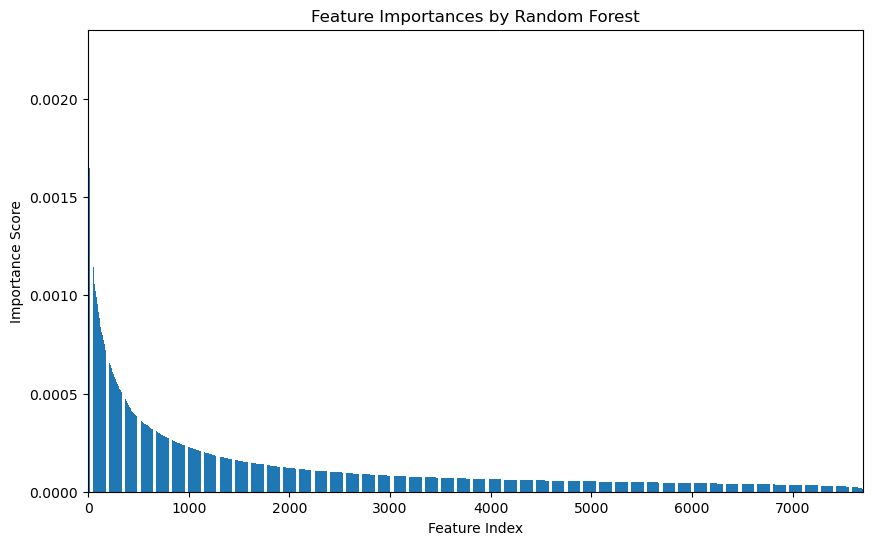

Feature ranking:
1. Feature 4812 (0.002241024931980336)
2. Feature 4811 (0.0019250449506798206)
3. Feature 4821 (0.0019086350778919525)
4. Feature 4902 (0.001891234149348659)
5. Feature 4904 (0.0018649492686137348)
6. Feature 676 (0.001826359388602489)
7. Feature 3490 (0.0018207890956788162)
8. Feature 3494 (0.0018078407208320837)
9. Feature 4819 (0.0017812004804442323)
10. Feature 718 (0.0017570710523619332)
11. Feature 4813 (0.0017558177087905566)
12. Feature 3493 (0.0017181661133597237)
13. Feature 64 (0.0016884447112738227)
14. Feature 4905 (0.0016781367042097348)
15. Feature 3416 (0.0016484541730985645)
16. Feature 1466 (0.0016306550079775869)
17. Feature 4810 (0.0016054172274861498)
18. Feature 4820 (0.0015504133545848242)
19. Feature 4815 (0.001514180543605577)
20. Feature 4763 (0.0015052242615014961)
21. Feature 4816 (0.0014904659529727715)
22. Feature 68 (0.0014794873594814748)
23. Feature 4809 (0.0014756933232446814)
24. Feature 3495 (0.0014642004267853745)
25. Feature 3491 (

In [16]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Train a Random Forest to determine feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Get feature importances from the Random Forest model
importances = rf.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances by Random Forest")
plt.bar(range(X_train_scaled.shape[1]), importances[indices], align="center")
plt.xlim([-1, X_train_scaled.shape[1]])
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train_scaled.shape[1]):
    print(f"{f + 1}. Feature {indices[f]} ({importances[indices[f]]})")


In [17]:
from sklearn.feature_selection import SelectFromModel

# Select top 100 important features
sfm = SelectFromModel(rf, threshold=-np.inf, max_features=100, prefit=True)
X_train_important = sfm.transform(X_train_scaled)
X_val_important = sfm.transform(X_val_scaled)
X_test_important = sfm.transform(X_test_scaled)

# Check the shape of the data after feature selection
print('Training data shape after feature selection:', X_train_important.shape)
print('Validation data shape after feature selection:', X_val_important.shape)
print('Test data shape after feature selection:', X_test_important.shape)


Training data shape after feature selection: (12682, 100)
Validation data shape after feature selection: (12683, 100)
Test data shape after feature selection: (10871, 100)


In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the SVM model
svm = SVC()

# Set up the hyperparameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_important, y_train)

# Output the best hyperparameters and best score
print('Best hyperparameters (SVM):', grid_search.best_params_)
print('Best cross-validation score (SVM):', grid_search.best_score_)

# Evaluate the best SVM model on the validation and test sets
best_svm = grid_search.best_estimator_
val_score_svm = best_svm.score(X_val_important, y_val)
test_score_svm = best_svm.score(X_test_important, y_test)
print('Validation accuracy (SVM):', val_score_svm)
print('Test accuracy (SVM):', test_score_svm)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   2.7s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   2.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   3.3s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   3.3s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   3.0s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   3.2s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   6.6s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   7.5s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   7.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   8.8s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   9.2s
[CV] END .....................C=0.1, gamma=scale

In [28]:
import numpy as np

# Assuming all previous code for data loading, preprocessing, and model training has been executed

def predict_word(svm_model, scaler, sfm, word, test_data, test_labels, feature_names_mapping, snippet_ids_test):
    """
    Predict the class label for a given word using the trained SVM model.

    :param svm_model: Trained SVM model
    :param scaler: StandardScaler used for feature scaling
    :param sfm: SelectFromModel used for feature selection
    :param word: Word to predict
    :param test_data: Test data set
    :param test_labels: Corresponding labels for the test data
    :param feature_names_mapping: Feature names mapping
    :param snippet_ids_test: Snippet IDs for the test set
    :return: Predicted class label
    """
    # Find the index of the given word in the test set
    word_index = np.where(test_labels == word)[0][0]
    
    # Get the corresponding features for the word
    word_features = test_data[word_index].reshape(1, -1)
    
    # Scale the features
    word_features_scaled = scaler.transform(word_features)
    
    # Select important features
    word_features_important = sfm.transform(word_features_scaled)
    
    # Predict the class label
    prediction = svm_model.predict(word_features_important)
    
    return prediction[0]

# Example usage:
# Use a word from the test set for prediction
example_word_index = 9  # Index of the word in the test set
example_word = y_test[example_word_index]

# Get the prediction for the example word
predicted_label = predict_word(best_svm, scaler, sfm, example_word, X_test_scaled, y_test, feature_names_mapping, snippet_ids_test)

# Print the result
print(f"Predicted label for the word '{example_word}' is: {predicted_label}")


Predicted label for the word 'Haus' is: other


In [30]:
import numpy as np

# Check the class distribution in the test set
unique, counts = np.unique(y_test, return_counts=True)
print(f"Class distribution in test set: {dict(zip(unique, counts))}")

def predict_word(svm_model, scaler, sfm, word_index, test_data, test_labels):
    """
    Predict the class label for a given word using the trained SVM model.

    :param svm_model: Trained SVM model
    :param scaler: StandardScaler used for feature scaling
    :param sfm: SelectFromModel used for feature selection
    :param word_index: Index of the word in the test data
    :param test_data: Test data set
    :param test_labels: Corresponding labels for the test data
    :return: Predicted class label
    """
    # Get the corresponding features for the word
    word_features = test_data[word_index].reshape(1, -1)
    
    # Scale the features
    word_features_scaled = scaler.transform(word_features)
    
    # Select important features
    word_features_important = sfm.transform(word_features_scaled)
    
    # Predict the class label
    prediction = svm_model.predict(word_features_important)
    
    return prediction[0]

# Example usage:
# Predict labels for a sample of words from the test set
sample_indices = np.random.choice(len(y_test), 100, replace=False)
for idx in sample_indices:
    example_word = y_test[idx]
    predicted_label = predict_word(best_svm, scaler, sfm, idx, X_test_scaled, y_test)
    print(f"True label: {example_word} | Predicted label: {predicted_label}")


Class distribution in test set: {'Alarm': 475, 'Brötchen': 504, 'Fernseher': 492, 'Haus': 494, 'Heizung': 510, 'Leitung': 476, 'Licht': 512, 'Lüftung': 493, 'Ofen': 479, 'Radio': 476, 'Schraube': 468, 'Spiegel': 512, 'Staubsauger': 516, 'an': 442, 'aus': 473, 'kann': 520, 'nicht': 489, 'offen': 457, 'other': 1103, 'warm': 493, 'wunderbar': 487}
True label: Brötchen | Predicted label: other
True label: kann | Predicted label: other
True label: kann | Predicted label: other
True label: kann | Predicted label: other
True label: Alarm | Predicted label: other
True label: Licht | Predicted label: other
True label: Lüftung | Predicted label: other
True label: Staubsauger | Predicted label: other
True label: Haus | Predicted label: other
True label: aus | Predicted label: other
True label: Haus | Predicted label: other
True label: other | Predicted label: other
True label: Spiegel | Predicted label: other
True label: other | Predicted label: other
True label: warm | Predicted label: other
Tru

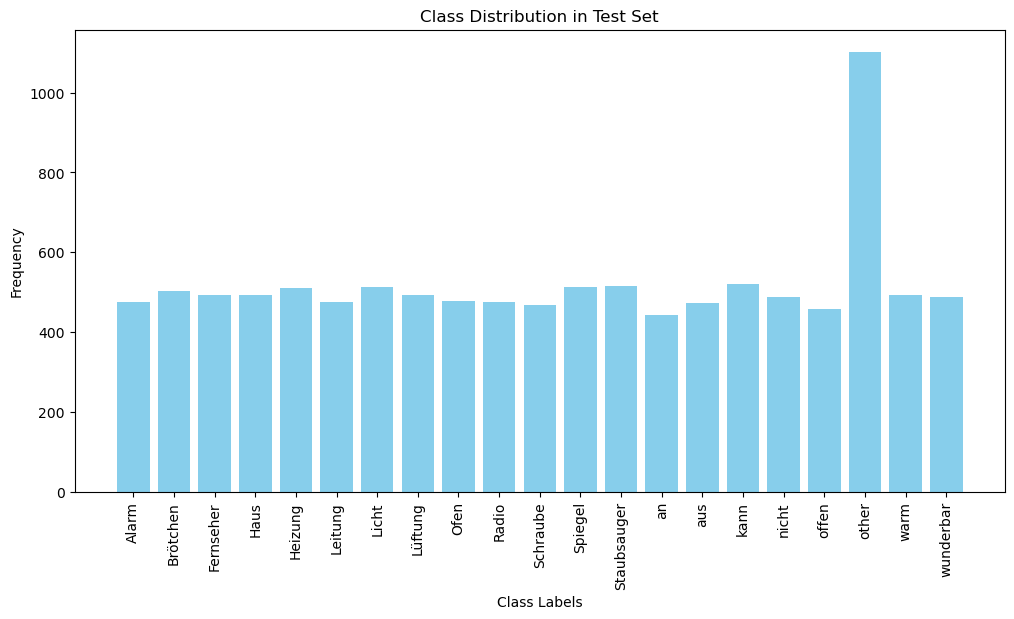

In [31]:
import matplotlib.pyplot as plt

# Calculate the class distribution in the test set
unique, counts = np.unique(y_test, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Plot the class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution in Test Set')
plt.xticks(rotation=90)
plt.show()


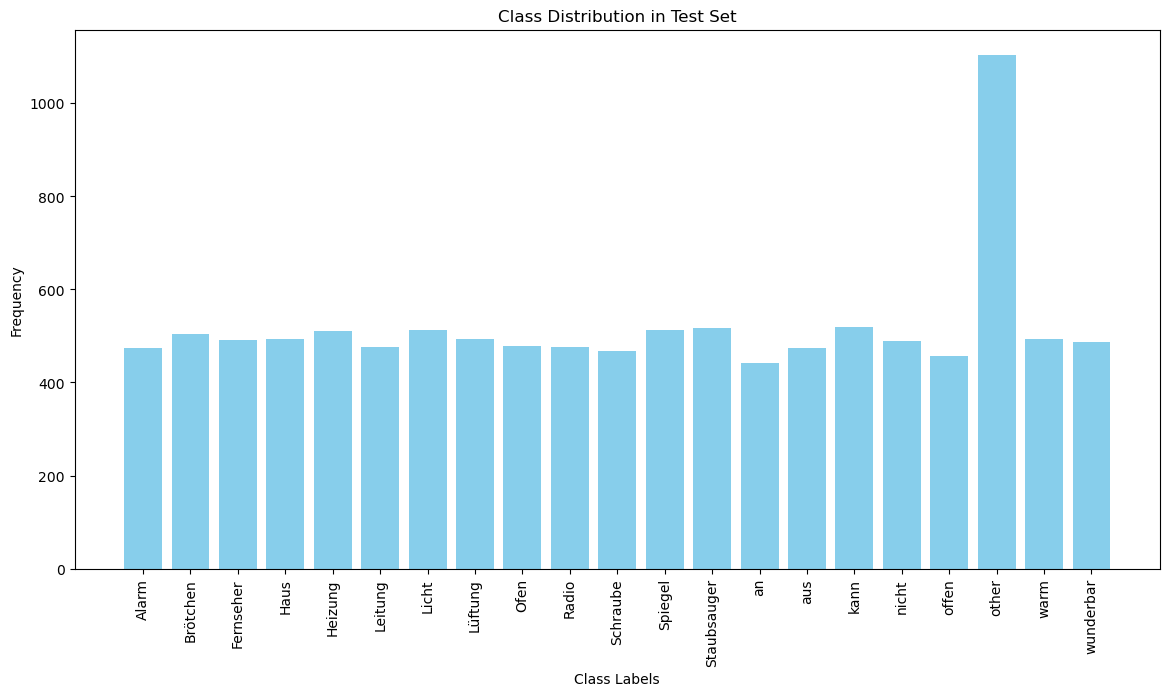

True label: Spiegel | Predicted label: other
True label: offen | Predicted label: other
True label: Spiegel | Predicted label: other
True label: Fernseher | Predicted label: other
True label: Spiegel | Predicted label: other
True label: offen | Predicted label: other
True label: Lüftung | Predicted label: other
True label: Staubsauger | Predicted label: other
True label: Haus | Predicted label: other
True label: Heizung | Predicted label: other
              precision    recall  f1-score   support

       Alarm       0.84      0.93      0.88       475
    Brötchen       0.94      0.93      0.93       504
   Fernseher       0.94      0.94      0.94       492
        Haus       0.84      0.86      0.85       494
     Heizung       0.94      0.93      0.94       510
     Leitung       0.94      0.91      0.92       476
       Licht       0.85      0.88      0.86       512
     Lüftung       0.96      0.94      0.95       493
        Ofen       0.81      0.74      0.77       479
       Rad

PermissionError: [Errno 1] Operation not permitted

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Check the class distribution in the test set
unique, counts = np.unique(y_test, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Plot the class distribution
plt.figure(figsize=(14, 7))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Class Distribution in Test Set')
plt.xticks(rotation=90)
plt.show()

# Define the predictor method
def predict_word(svm_model, scaler, sfm, word_index, test_data, test_labels):
    """
    Predict the class label for a given word using the trained SVM model.

    :param svm_model: Trained SVM model
    :param scaler: StandardScaler used for feature scaling
    :param sfm: SelectFromModel used for feature selection
    :param word_index: Index of the word in the test data
    :param test_data: Test data set
    :param test_labels: Corresponding labels for the test data
    :return: Predicted class label
    """
    # Get the corresponding features for the word
    word_features = test_data[word_index].reshape(1, -1)
    
    # Scale the features
    word_features_scaled = scaler.transform(word_features)
    
    # Select important features
    word_features_important = sfm.transform(word_features_scaled)
    
    # Predict the class label
    prediction = svm_model.predict(word_features_important)
    
    return prediction[0]

# Example usage:
# Predict labels for a sample of words from the test set
sample_indices = np.random.choice(len(y_test), 10, replace=False)
for idx in sample_indices:
    example_word = y_test[idx]
    predicted_label = predict_word(best_svm, scaler, sfm, idx, X_test_scaled, y_test)
    print(f"True label: {example_word} | Predicted label: {predicted_label}")

# Evaluate detailed performance metrics
y_pred = best_svm.predict(X_test_important)
print(classification_report(y_test, y_pred))

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix
import seaborn as sns

plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique, yticklabels=unique)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [34]:
# Define the SVM model with class weights
svm_weighted = SVC(class_weight='balanced')

# Set up the hyperparameter grid for GridSearchCV
param_grid_weighted = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Set up GridSearchCV with cross-validation
grid_search_weighted = GridSearchCV(svm_weighted, param_grid_weighted, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_weighted.fit(X_train_important, y_train)

# Output the best hyperparameters and best score
print('Best hyperparameters (SVM with class weights):', grid_search_weighted.best_params_)
print('Best cross-validation score (SVM with class weights):', grid_search_weighted.best_score_)

# Evaluate the best SVM model on the validation and test sets
best_svm_weighted = grid_search_weighted.best_estimator_
val_score_svm_weighted = best_svm_weighted.score(X_val_important, y_val)
test_score_svm_weighted = best_svm_weighted.score(X_test_important, y_test)
print('Validation accuracy (SVM with class weights):', val_score_svm_weighted)
print('Test accuracy (SVM with class weights):', test_score_svm_weighted)

# Predict on the test set with the new model
y_pred_weighted = best_svm_weighted.predict(X_test_important)

# Print detailed classification report for the new model
print(classification_report(y_test, y_pred_weighted))

# Print the confusion matrix for the new model
conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)
print("Confusion Matrix (weighted):\n", conf_matrix_weighted)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


PermissionError: [Errno 1] Operation not permitted

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the test set
y_pred = best_svm.predict(X_test_important)

# Print detailed classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


              precision    recall  f1-score   support

       Alarm       0.84      0.93      0.88       475
    Brötchen       0.94      0.93      0.93       504
   Fernseher       0.94      0.94      0.94       492
        Haus       0.84      0.86      0.85       494
     Heizung       0.94      0.93      0.94       510
     Leitung       0.94      0.91      0.92       476
       Licht       0.85      0.88      0.86       512
     Lüftung       0.96      0.94      0.95       493
        Ofen       0.81      0.74      0.77       479
       Radio       0.96      0.95      0.95       476
    Schraube       0.93      0.96      0.94       468
     Spiegel       0.94      0.95      0.94       512
 Staubsauger       0.96      0.91      0.93       516
          an       0.83      0.88      0.86       442
         aus       0.84      0.84      0.84       473
        kann       0.87      0.88      0.88       520
       nicht       0.89      0.86      0.87       489
       offen       0.73    

In [38]:
# Define the SVM model with class weights
svm_weighted = SVC(class_weight='balanced')

# Set up the hyperparameter grid for GridSearchCV
param_grid_weighted = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Set up GridSearchCV with cross-validation
grid_search_weighted = GridSearchCV(svm_weighted, param_grid_weighted, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search_weighted.fit(X_train_important, y_train)

# Output the best hyperparameters and best score
print('Best hyperparameters (SVM with class weights):', grid_search_weighted.best_params_)
print('Best cross-validation score (SVM with class weights):', grid_search_weighted.best_score_)

# Evaluate the best SVM model on the validation and test sets
best_svm_weighted = grid_search_weighted.best_estimator_
val_score_svm_weighted = best_svm_weighted.score(X_val_important, y_val)
test_score_svm_weighted = best_svm_weighted.score(X_test_important, y_test)
print('Validation accuracy (SVM with class weights):', val_score_svm_weighted)
print('Test accuracy (SVM with class weights):', test_score_svm_weighted)

# Predict on the test set with the new model
y_pred_weighted = best_svm_weighted.predict(X_test_important)

# Print detailed classification report for the new model
print(classification_report(y_test, y_pred_weighted))

# Print the confusion matrix for the new model
conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)
print("Confusion Matrix (weighted):\n", conf_matrix_weighted)


Fitting 3 folds for each of 18 candidates, totalling 54 fits


PermissionError: [Errno 1] Operation not permitted